This is an individual-based epidemic model, using data from the 2001 UK foot and mouth epidemic.

A ring-cull policy around identified herds can be utilised, RingCull sets the radius of the ring. As an example you may wish to try: 
<br>
Y0 = 1
<br>
RingCull = 0
<br>
MaxTime = 1000
<br>

Status=0     => Susceptible
<br>
Status=1-5   => Exposed
<br>
Status=6-11  => Infectious
<br>
Status=10-11 => Reported but still Infectious
<br>
Status=12-   => Culled but waiting local ring culling
<br>
Status=-1    => Cull

In [106]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import matplotlib.pyplot as plt
import math
infinity = math.inf

In [112]:
def Kernel(dist_squared):
    P=[-9.2123e-5, 9.5628e-4, 3.3966e-3, -3.3687e-2, -1.30519e-1, -0.609262, -3.231772]
    if dist_squared < 0.0138:
        K = 0.3093 
    elif dist_squared > 10*10:
        K = 0
    else:
        K=np.exp(np.polyval(P,dist_squared))
        
    return K

In [113]:
def KernelMat(dist_squared):
    P=[-9.2123e-5, 9.5628e-4, 3.3966e-3, -3.3687e-2, -1.30519e-1, -0.609262, -3.231772]

    K=np.zeros(np.size(dist_squared))
    for i in range(np.size(dist_squared)):
        if dist_squared[i] < 0.0138:
            K[i] = 0.3093 
        elif dist_squared[i] > 16.7304:
            K[i] = 0
        else:
            K[i]=np.exp(np.polyval(P,dist_squared[i]))
        
    return K

In [114]:
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    G=np.floor(x*XNum/XRange)*YNum+np.floor(y*YNum/YRange)+1
    G = [int(i) for i in G]
    return G

In [115]:
# Iteration Space
def Iterate(Status, x, y, Suscept, Transmiss, RingCull, grid, first_in_grid, last_in_grid, Num, MaxRate):
    Event = np.zeros(np.size(Status))
    INF = [i for i in range(np.size(Status)) if (Status[i]>5) and (Status[i]<12)]
    NI=np.size(INF) # Number of reported farms still infectious
    IGrids=[int(grid[i]) for i in INF]
    #print(IGrids)
    if NI > 0:
        for i in range(NI):
            INFi=INF[i]
            MaxProb=1-np.exp(-Transmiss[INFi]*np.multiply(Num, MaxRate[IGrids[i]-1,:]))
            randomMat = np.random.rand(int(np.max(grid)))
            vals = MaxProb - randomMat
            m = [int(j) for j in range(np.size(vals)) if vals[j] > 0]
            for n in range(np.size(m)):
                s=1
                M=int(m[n])
                PAB=1-np.exp(-Transmiss[INFi]*MaxRate[IGrids[i],M])
                if PAB==1:
                    ind=np.arange(first_in_grid[M],last_in_grid[M])
                    susceptind = np.zeros(np.size(ind))
                    xind = np.zeros(np.size(ind))
                    yind = np.zeros(np.size(ind))
                    statusind = np.zeros(np.size(ind))
                    
                    for j in range(np.size(ind)):
                        susceptind[j] = Suscept[int(ind[j])] #Susceptibility of farm at index ind[i]
                        xind[j] = x[int(ind[j])] #x corodinate of farm at index ind[i]
                        yind[j] = y[int(ind[j])] #y corodinate of farm at index ind[i]
                        statusind[j] = Status[int(ind[j])] #status of farm at index ind[i]
                    
                    Q=1-np.exp(np.multiply(-Transmiss[INFi]*susceptind, KernelMat((x[INFi]-xind)**2+(y[INFi]-yind)**2)))
                    randMat2 = np.random.rand(np.size(Q))-Q
                    indrandMat = [int(i) for i in range(np.size(randMat2)) if randMat2[i] < 0]
                    statusmatind = [int(i) for i in range(np.size(statusind)) if statusind[i] == 0]
                    indMat = list(set(indrandMat).intersection(statusmatind))
                    for k in indMat:
                        Event[k] = 1
                    #print('Event', Event)
                    #plt.pause(10)
                else:
                    for j in range(int(Num[M])):
                        ind=first_in_grid[M]+j
                        P=1-s*(1-PAB)**(int(int(Num[M])-int(j)))
                        R=np.random.rand()
                        if R<PAB/P:
                            s=0
                            Q=1-np.exp(-Transmiss[int(INFi)]*Suscept[int(ind)]*Kernel((x[int(INFi)]-x[int(ind)])**2+(y[int(INFi)]-y[int(ind)])**2))
                            if (R<Q/P) and (Status[int(ind)]==0):
                                Event[int(ind)]=1
    
    m = [int(i) for i in range(np.size(Status)) if Status[i] > 0]
    for i in m:
        Status[i]=Status[i]+1
        
    Status=Status+Event

    m=[i for i in range(np.size(Status)) if Status[i]==13] # Initiate Ring Culling Around Reported Farm
    if np.size(m) > 0:
        for i in range(np.size(m)):
            Status[m[i]]=-1
            D=(x[m[i]]-x[:])**2+(y[m[i]]-y[:])**2
            n = [i for i in range(np.size(D)) if D[i] < RingCull**2]
            for i in range(np.size(n)):
                Status[n[i]] = -1
        
    return Status

<IPython.core.display.Javascript object>


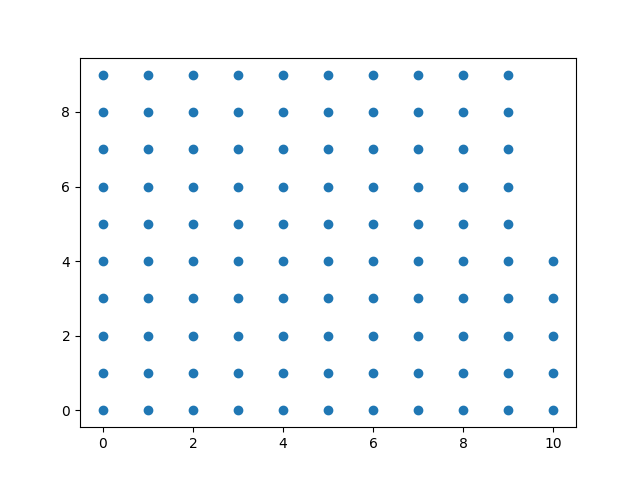

/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [116]:
%matplotlib notebook

Y0=10
RingCull = 1
MaxTime = 1000
farmData = pd.read_csv('FarmData2001', 
                       names = ["County Number", "Parish Number", "Holding Number", "X Coordinate", "Y Coordinate", "Farm Area", 
                                "Number of Cattle", "Number of Pigs", "Number of Sheep", "Number of Goats", "Number of other Animals"], delim_whitespace=True)
cumbData = farmData[farmData['County Number'] == 8]
#cumbData = farmData
cumbData = cumbData.reset_index(drop=True)
xCumb = cumbData['X Coordinate']/1000
yCumb = cumbData['Y Coordinate']/1000
cumbCattle = cumbData['Number of Cattle']
cumbSheep = cumbData['Number of Sheep']
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
x = xCumb - xmin #Shift to start from (0, 0)
y = yCumb - ymin #Shift to start from (0, 0)
Cows = abs(cumbCattle) #Number of cows on each farm
Sheep = abs(cumbSheep) #Number of sheep on each farm
N = np.size(x); #Number of farms
infectInd = np.arange(0, Y0)
#Indices of the initially exposed farms
Status = np.zeros(N)
for i in infectInd:
    Status[i] = 1 #Setting status of exposed farms to 1

R = np.random.rand(N)

Suscept = Sheep  + 10.5*Cows #Susceptibility of each farm
Transmiss = 5.1e-7*Sheep + 7.7e-5*Cows #Transmissibility of each farm




grid = WhichGrid(x,y,sizex,sizey,10,10)
tmp=np.sort(grid)
ind=np.argsort(grid)
ind = np.arange(np.size(grid))
x=[x.values[i] for i in ind]
y=[y.values[i] for i in ind]
Status=[Status[i] for i in ind]
grid=[grid[i] for i in ind]
Sheep = [Sheep.values[i] for i in ind]
Cows = [Cows.values[i] for i in ind]
Suscept=[Suscept.values[i] for i in ind]
Transmiss = [Transmiss.values[i] for i in ind]
vecSize = int(np.max(grid))
Xgrid = np.zeros(vecSize)
Ygrid = np.zeros(vecSize)
Num = np.zeros(vecSize)
first_in_grid = np.zeros(vecSize)
last_in_grid = np.zeros(vecSize)
Max_Sus_grid = np.zeros(vecSize)
MaxRate = np.zeros((vecSize, vecSize))
for i in range(int(np.max(grid))):
    Xgrid[i]=np.floor(i/10)
    Ygrid[i]=i%10
    m=[int(j) for j in range(np.size(grid)) if grid[j]==i]
    Num[i] = np.size(m)
    if Num[i]>0:
        first_in_grid[i]=np.min(m)
        last_in_grid[i]=np.max(m)
        Max_Sus_grid[i] = np.max([Suscept[j] for j in m])
    else:
        first_in_grid[i]=0
        last_in_grid[i]=-1
        Max_Sus_grid[i]=0

for i in range(vecSize):
    for j in range(vecSize):
        if i==j or Num[i]==0 or Num[j]==0:
            MaxRate[i, j]=infinity
        else:
            Dist2=(sizex*(np.max([0, (abs(Xgrid[i]-Xgrid[j])-1)])/10))**2 + (sizey*(np.max([0, (abs(Ygrid[i]-Ygrid[j])-1)])/10))**2
            MaxRate[i,j]=np.multiply(Max_Sus_grid[j],Kernel(Dist2));




#Susceptible, Exposed, Infectious, Reported.
i=0
S = []
E = []
I = []
R = []
R2 = []
CullSheep = []
CullCattle = []
t = []
t.append(0)
time = 0
S.append(np.size([i for i in Status if i == 0]))
E.append(np.size([i for i in Status if (i > 0) and (i <= 5)]))
I.append(np.size([i for i in Status if (i > 5) and (i <= 9)]))
R.append(np.size([i for i in Status if i == 10]))
R2.append(np.size([i for i in Status if i > 9]))
CullSheep.append(0)
CullCattle.append(0)
IterateFlag=1

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion

fig.show()
fig.canvas.draw()

while (time < MaxTime) and (IterateFlag==1):
    Status=Iterate(Status, x, y, Suscept, Transmiss, RingCull, grid, first_in_grid, last_in_grid, Num, MaxRate)
    Sus = [int(i) for i in range(np.size(Status)) if Status[i] == 0]
    Exp = [int(i) for i in range(np.size(Status)) if (Status[i] > 0) and (Status[i]) <= 5]
    Inf = [int(i) for i in range(np.size(Status)) if (Status[i] > 5) and (Status[i]) <= 9]
    Rep = [int(i) for i in range(np.size(Status)) if Status[i] > 9]
    Culled = [int(i) for i in range(np.size(Status)) if Status[i] < 0]
    S.append(np.size(Sus))
    E.append(np.size(Exp))
    I.append(np.size(Inf))
    R.append(np.size([i for i in Status if i == 10]))
    R2.append(np.size(Rep))
    culledsheep = [Sheep[i] for i in Culled]
    culledcattle = [Cows[i] for i in Culled]
    CullSheep.append(np.sum(culledsheep))
    CullCattle.append(np.sum(culledcattle))
    t.append(t[i-1]+1)
    time +=1
    i += 1
    
    if t[-1]>5:
        if E[-4]+I[-4]+R2[-4]==0:
            IterateFlag=0
    

    xculledplot = [x[i] for i in Culled]
    xsusplot = [x[i] for i in Sus]
    xexpplot = [x[i] for i in Exp]
    xinfplot = [x[i] for i in Inf]
    xrepplot = [x[i] for i in Rep]
    
    yculledplot = [y[i] for i in Culled]
    ysusplot = [y[i] for i in Sus]
    yexpplot = [y[i] for i in Exp]
    yinfplot = [y[i] for i in Inf]
    yrepplot = [y[i] for i in Rep]
    
    ax.clear()
    ax.scatter(xculledplot, yculledplot, c='k', marker='.', s=10, label='Culled')
    ax.scatter(xsusplot, ysusplot, c='g', marker='o', s=6, label='Susceptible')
    ax.scatter(xexpplot, yexpplot, c=[0.9, 0.9, 0], marker='o', s=8, label='Exposed')
    ax.scatter(xinfplot, yinfplot, c=[1, 0.5, 0], marker='o', s=10, label='Infectious')
    ax.scatter(xrepplot, yrepplot, c='r', marker='o', s=10, label='Reported')
    ax.axis([0, sizex, 0, sizey])
    ax.legend()
    fig.canvas.draw()
    plt.pause(0.5)
    

In [117]:
ax.clear()
plt.scatter(Xgrid, Ygrid)

In [ ]:
np.arange(0,-1)

In [118]:
np.max([0, 1, 2])

2